In [1]:
import pandas as pd
import xlrd
from functions import *
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
book = xlrd.open_workbook('CTG.xls')

In [3]:
book.sheet_names()

['Description', 'Data', 'Raw Data']

In [4]:
data_sh = book.sheet_by_index(1)
raw_data_sh = book.sheet_by_index(2)

In [5]:
data = pd.read_excel('./CTG.xls',sheet_name = 'Raw Data').dropna(axis=0)

In [6]:
data = data.loc[:,['ASTV', 'MLTV', 'Max', 'Median','NSP']]

In [7]:
data['Class'] = [1 if c == 1 else 0 for c in data.NSP]

In [8]:
data.drop(['NSP'], axis=1
         , inplace = True)

In [9]:
gnb = GaussianNB()
logreg = LogisticRegression()
dt = DecisionTreeClassifier()
no_hyper_models = [gnb,logreg,dt]
rf = RandomForestClassifier()
svc = SVC()

In [10]:
X_train, X_test = train_test_split(data, test_size = .5, random_state = 1)
y_train = X_train.pop('Class')
y_test = X_test.pop('Class')
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Schematic:

1. Take list of models
2. For each:
    * generate predictions
    * compile & add statistics to dataframe

RandomForest

In [11]:
results = pd.DataFrame(columns = ['TP','FP','TN','FN','accuracy','TPR',
                              'TNR'],index = [])
for clf in no_hyper_models:
    clf.fit(X_train,y_train)
    preds = clf.predict(X_test)
    compile_results(results,clf,preds,true = y_test.values)

In [12]:
results

,TP,FP,TN,FN,accuracy,TPR,TNR
GaussianNB,737.0,105.0,139.0,82.0,0.82,0.90,0.57
LogisticRegression,773.0,147.0,97.0,46.0,0.82,0.94,0.40
DecisionTreeClassifier,759.0,67.0,177.0,60.0,0.88,0.93,0.73


In [13]:
test_results = []
for d in range(1,6):
    for n in range(1,11):
        rf = RandomForestClassifier(criterion = 'entropy', 
                                    n_estimators=n,
                                    max_depth=d,random_state=1)
        rf.fit(X_train,y_train)
        test_results.append((d,n,accuracy_score(y_test,rf.predict(X_test))))
        # rf.score(train_X,train_y)
        

In [14]:
results_df = pd.DataFrame(test_results, columns = ['d','n','accuracy'])
results_df['error'] = 1 - results_df['accuracy']

In [15]:
results_df[results_df.accuracy == 
results_df.loc[results_df['accuracy'].idxmax(),'accuracy']]

,d,n,accuracy,error
48,5,9,0.901223,0.098777


In [16]:
rf = RandomForestClassifier(criterion = 'entropy', 
                                    n_estimators=9,
                                    max_depth=5,random_state=1)

In [17]:
rf.fit(X_train,y_train)
preds = rf.predict(X_test)
results = compile_results(results,rf,preds,y_test)
results

,TP,FP,TN,FN,accuracy,TPR,TNR
GaussianNB,737,105,139,82,0.82,0.90,0.57
LogisticRegression,773,147,97,46,0.82,0.94,0.40
DecisionTreeClassifier,759,67,177,60,0.88,0.93,0.73
RandomForestClassifier,797,83,161,22,0.90,0.97,0.66


[Text(0.5, 1.0, 'RF Error')]

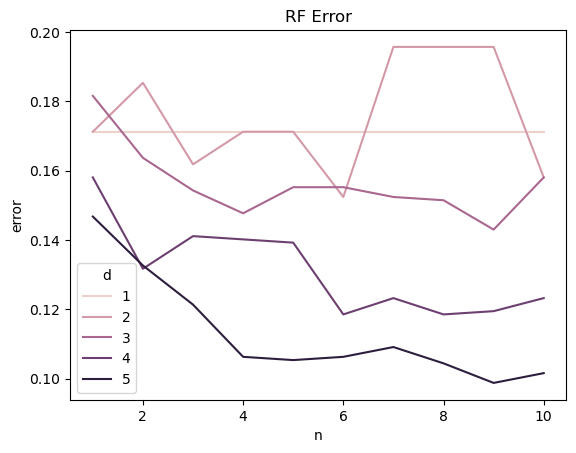

In [18]:
sns.lineplot(results_df, x = 'n', y = 'error', hue='d').set(title = f'RF Error')

In [19]:
clf = SVC(kernel = "linear", degree = 1)
clf.fit(X_train,y_train)
preds = clf.predict(X_test)
compile_results(results,clf,preds,y_test, 'SVC_linear')

,TP,FP,TN,FN,accuracy,TPR,TNR
GaussianNB,737,105,139,82,0.82,0.90,0.57
LogisticRegression,773,147,97,46,0.82,0.94,0.40
DecisionTreeClassifier,759,67,177,60,0.88,0.93,0.73
RandomForestClassifier,797,83,161,22,0.90,0.97,0.66
SVC_linear,774,147,97,45,0.82,0.95,0.40


In [20]:
clf = SVC(kernel = "poly", degree = 2)
clf.fit(X_train,y_train)
preds = clf.predict(X_test)
compile_results(results,clf,preds,y_test, 'SVC_degree2')

,TP,FP,TN,FN,accuracy,TPR,TNR
GaussianNB,737,105,139,82,0.82,0.90,0.57
LogisticRegression,773,147,97,46,0.82,0.94,0.40
DecisionTreeClassifier,759,67,177,60,0.88,0.93,0.73
RandomForestClassifier,797,83,161,22,0.90,0.97,0.66
SVC_linear,774,147,97,45,0.82,0.95,0.40
SVC_degree2,811,200,44,8,0.80,0.99,0.18


In [21]:
clf = SVC(kernel = "rbf")
clf.fit(X_train,y_train)
preds = clf.predict(X_test)
compile_results(results,clf,preds,y_test, 'SVC_gaussian')

,TP,FP,TN,FN,accuracy,TPR,TNR
GaussianNB,737,105,139,82,0.82,0.90,0.57
LogisticRegression,773,147,97,46,0.82,0.94,0.40
DecisionTreeClassifier,759,67,177,60,0.88,0.93,0.73
RandomForestClassifier,797,83,161,22,0.90,0.97,0.66
SVC_linear,774,147,97,45,0.82,0.95,0.40
SVC_degree2,811,200,44,8,0.80,0.99,0.18
SVC_gaussian,790,83,161,29,0.89,0.96,0.66


One way to find the importance of features would be to start from scratch.  try each feature individually, proceed with the best feature per test set or validation results.  Next, try adding each remaining feature to the model one at a time.  proceed with the feature that improves the test set the most.  then try removing each feature one at a time (one fewer features than full model) and see if any previously included features are now redundant and lead to overfitting.  proceed until no additional features lead to a statistically significant improvement.